# Artificial mental phenomena: Psychophysics as a framework to detect perception biases in AI models

Lizhen Liang and Daniel E. Acuna  
School of Information Studies      
Syracuse University  
Science of Science & Computational Discovery Lab  
Syracuse, New York

## Part 1: Two Alternative Forced Choice

Load Spark & Load Packages

In [1]:
import os
import findspark

os.environ['PATH'] = os.environ['PATH'] + ":/usr/java/jdk1.8.0_162/bin"

import findspark
os.environ['PYSPARK_SUBMIT_ARGS'] = \
    "--packages com.databricks:spark-xml_2.11:0.5.0 pyspark-shell"
findspark.init('/opt/cloudera/parcels/SPARK2/lib/spark2/')

from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName('Bias').\
    config('spark.driver.memory', '10g').\
    config('spark.network.timeout', '600s').\
    config('spark.driver.maxResultSize', '10g').\
    config('spark.executor.memory', '10g').\
    config('spark.kryoserializer.buffer.max', '1g').getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

Load Data & Load Models

Using wiki dataset, we have bootstrapped 32 GloVe word embeddings models. 

Loading the models

In [7]:
models = []
for i in range(2, 10):
    for j in range(0, 4):
        models.append(KeyedVectors.load_word2vec_format("/home/lliang06/Bias_paper/w2v_" + str(i) + str(j) + ".txt"))

In [9]:
# The number of word2vec models, in our case, 32
num_models = len(models)

### 2AFC Experiment

In [10]:
from scipy.spatial.distance import cosine

In [11]:
def similarity(x, y):
    return 1 - cosine(x, y)

In [12]:
# run experiment
def twoafc_experiment(left_embedding, right_embedding, target_embeddings):
    decisions = []
    for embedding in target_embeddings:
        for idx in range(0, 100, 1):
            alpha = idx/100
            # woman*n*(1-alpha) man*n*alpha great ____
            left_score = (1-alpha) + \
                alpha*similarity(left_embedding, right_embedding) + \
                similarity(left_embedding, embedding)
            right_score = (1-alpha)*similarity(right_embedding, left_embedding) + \
                alpha + \
                + similarity(right_embedding, embedding)
            d = int(right_score > left_score)
            decisions.append([alpha, d])
    return pd.DataFrame(np.array(decisions), columns=['alpha', 'd'])

In [13]:
def bisect_search(left_word, right_word, target_word, model, delta_alpha=1/100):
    left_token = model.wv.get_vector(left_word)
    right_roken = model.wv.get_vector(right_word)
    target_token = model.wv.get_vector(target_word)
    min_alpha = 0
    max_alpha = 1
    c = 0
    def eval_alpha(alpha):
        left_score = (1-alpha) + \
                alpha*similarity(left_token, right_roken) + \
                similarity(left_token, target_token)
        right_score = (1-alpha)*similarity(right_roken, left_token) + \
            alpha + \
            + similarity(right_roken, target_token)
        return left_score, right_score
    
    while (max_alpha-min_alpha) > delta_alpha:
        min_left_score, min_right_score = eval_alpha(min_alpha)
        min_alpha_d = int(min_right_score > min_left_score)
        max_left_score, max_right_score = eval_alpha(max_alpha)
        max_alpha_d = int(max_right_score > max_left_score)
        
        middle_left_score, middle_right_score = eval_alpha((min_alpha + max_alpha)/2)
        middle_alpha_d = int(middle_right_score > middle_left_score)        

        if middle_alpha_d != min_alpha_d:
            max_alpha = (min_alpha + max_alpha) / 2
        elif middle_alpha_d != max_alpha_d :
            min_alpha = (min_alpha + max_alpha) / 2
        else:
            break
        c += 1
        if c > 10:
            break
    return (min_alpha + max_alpha) / 2

/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


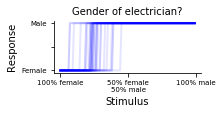

In [14]:
plt.figure(figsize=(3, 1.5))
for i in range(32):
    d = twoafc_experiment(models[i].wv.get_vector('woman'), 
                      models[i].wv.get_vector('man'),
                      [models[i].wv.get_vector('electrician')])
    plt.plot(d['alpha'], d['d'], 'b', alpha=0.1, linewidth=2);
plt.gca().tick_params(axis='both', which='major', labelsize=7)
plt.xticks([0, 0.5, 1], ['100% female', '50% female\n50% male', '100% male']);
plt.yticks([0, 0.5, 1], ['Female', '', 'Male']);
plt.xlabel('Stimulus', fontsize=10);
plt.ylabel('Response', fontsize=10);
plt.title('Gender of electrician?', fontsize=10);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('./2afc_example.pdf')

## Occupation

In [15]:
def process_string_to_list(s):
    return s.replace(' ', '').replace('\n', '').split(',')

From Bureau Labor Statistics, we found catagories of occupations. From those categories we picked 50 occupations that are representative. 

In [16]:
careers = process_string_to_list(
"""
technician, accountant, supervisor, engineer, worker, educator, clerk, counselor,
inspector, mechanic, manager, therapist, administrator, salesperson, receptionist, librarian,
advisor, pharmacist, janitor, psychologist, physician, carpenter, nurse, investigator,
bartender, specialist, electrician, officer, pathologist, teacher, lawyer, planner, practitioner,
plumber, instructor, surgeon, veterinarian, paramedic, examiner, chemist, machinist,
appraiser, nutritionist, architect, hairdresser, baker, programmer, paralegal, hygienist,
scientist""")

We want to compare occupations and two pairs of contradictory concepts: love vs. hate and woman vs. man to see if we can detect any biases from the PSE.

In [17]:
male = ['man', 'male', 'he', 'his', 'him', 'boy', 'brother', 'son']
female = ['woman', 'female', 'she', 'her', 'hers', 'girl', 'sister', 'daughter']

In [18]:
gender_pairs = []
gender_pairs.append(['woman', 'man'])
gender_pairs.append(['female', 'male'])
gender_pairs.append(['she', 'he'])
gender_pairs.append(['her', 'him'])
gender_pairs.append(['hers', 'his'])
gender_pairs.append(['daughter', 'son'])
gender_pairs.append(['girl', 'boy'])
gender_pairs.append(['sister', 'brother'])

In [19]:
gender_dict = {}
gender_dict['career'] = []
gender_dict['Left'] = []
gender_dict['Right'] = []
for i in range(num_models):
    gender_dict['pse_' + str(i)] = []
for n in careers:
    for pair in gender_pairs:
        gender_dict['Left'].append(pair[0])
        gender_dict['Right'].append(pair[1])
        gender_dict['career'].append(n)
        for i in range(32):
            gender_dict['pse_' + str(i)].append(None)
handpicked_gender_pse = pd.DataFrame(gender_dict)

In [20]:
R, C = handpicked_gender_pse.shape

In [21]:
for i in range(R):
    for j in range(num_models):
        n = handpicked_gender_pse.loc[i]['career']
        l = handpicked_gender_pse.loc[i]['Left']
        r = handpicked_gender_pse.loc[i]['Right']
        handpicked_gender_pse.loc[i]['pse_'+str(j)] = int(100*bisect_search(l, r, n, models[j], delta_alpha=1/100))

/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [22]:
handpicked_gender_pse['mean'] = handpicked_gender_pse.loc[:][['pse_0', 'pse_1', 'pse_2', 'pse_3', 'pse_4', 'pse_5', 'pse_6', 'pse_7', 'pse_8', 'pse_9', 
                         'pse_10', 'pse_11', 'pse_12', 'pse_13', 'pse_14', 'pse_15', 'pse_16', 'pse_17', 'pse_18', 
                         'pse_19', 'pse_20', 'pse_21', 'pse_22', 'pse_23', 'pse_24', 'pse_25', 'pse_26', 'pse_27',
                         'pse_28', 'pse_29', 'pse_30', 'pse_31']].mean(axis = 1)

handpicked_gender_pse['std'] = handpicked_gender_pse.loc[:][['pse_0', 'pse_1', 'pse_2', 'pse_3', 'pse_4', 'pse_5', 'pse_6', 'pse_7', 'pse_8', 'pse_9', 
                         'pse_10', 'pse_11', 'pse_12', 'pse_13', 'pse_14', 'pse_15', 'pse_16', 'pse_17', 'pse_18', 
                         'pse_19', 'pse_20', 'pse_21', 'pse_22', 'pse_23', 'pse_24', 'pse_25', 'pse_26', 'pse_27',
                         'pse_28', 'pse_29', 'pse_30', 'pse_31']].std(axis = 1)

In [23]:
avg_mean_std = handpicked_gender_pse[['career', 'mean', 'std']].groupby(['career']).mean()

In [24]:
avg_mean_std.head()

,mean,std
career,,
accountant,37.253906,6.353868
administrator,30.433594,11.356400
advisor,29.757812,10.059517
appraiser,45.941406,9.560056
architect,32.062500,8.372463


In [25]:
allpairs_avg = handpicked_gender_pse.loc[:, ['career', 'Left', 'Right', 'mean', 'std']]

In [26]:
allpairs_avg.head()

,career,Left,Right,mean,std
0,technician,woman,man,19.25000,5.690966
1,technician,female,male,52.46875,9.951445
2,technician,she,he,49.21875,5.580695
3,technician,her,him,56.71875,4.622765
4,technician,hers,his,17.68750,3.946722


In [27]:
allpairs_avg['Left_Right'] = None
for i in range(len(allpairs_avg)):
    allpairs_avg['Left_Right'][i] = allpairs_avg['Left'][i] + '_' + allpairs_avg['Right'][i]

/home/tozeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
allpairs_avg.to_csv('allcues.csv')

In [29]:
allpairs_avg = allpairs_avg.drop(columns=['Left', 'Right'])

In [30]:
df_avg = allpairs_avg.groupby(["career"]).mean()

In [31]:
df_avg = df_avg.sort_values(by = ["mean"])# .iloc[::2]

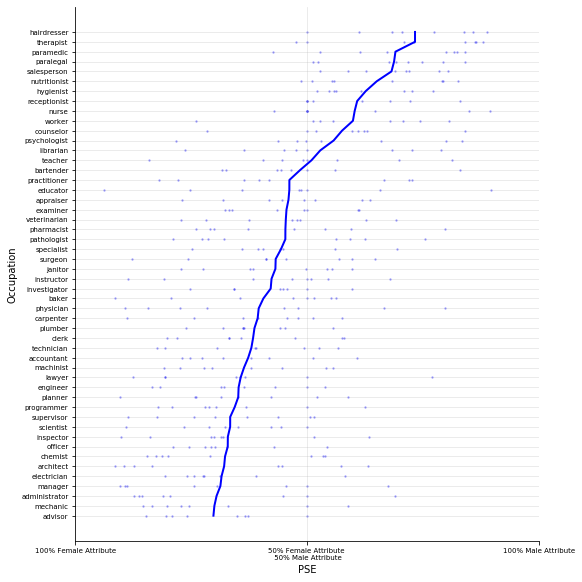

In [32]:
plt.figure(figsize = (8, 8))
plt.plot(df_avg["mean"].values, df_avg.index.values, linewidth = 2, c = 'b')
plt.scatter(x = allpairs_avg.loc[allpairs_avg['career'].isin(df_avg.index)]['mean'].values, y = allpairs_avg.loc[allpairs_avg['career'].isin(df_avg.index)]['career'].values, s = 2, alpha = 0.3, c = 'b')
plt.gca().tick_params(axis='both', which='major', labelsize=7)
plt.xticks([0, 50, 100], ['100% Female Attribute', '50% Female Attribute \n 50% Male Attribute', '100% Male Attribute']);
# plt.yticks([0, 0.5, 1], ['No', '', 'Yes']);
plt.xlabel('PSE', fontsize=10);
plt.ylabel('Occupation', fontsize=10);
# plt.title('Is it a male plumber?', fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.grid(alpha=0.3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("all_gender_pse_scatter_alloccupations.pdf")

In [33]:
df_avg = df_avg.sort_values(by = ["std"])

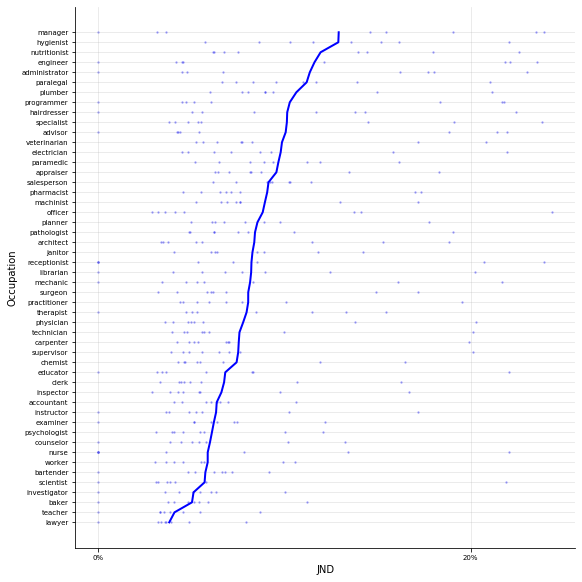

In [34]:
plt.figure(figsize = (8, 8))
plt.plot(df_avg["std"].values, df_avg.index.values, linewidth = 2, c = 'b')
plt.scatter(x = allpairs_avg.loc[allpairs_avg['career'].isin(df_avg.index)]['std'].values, y = allpairs_avg.loc[allpairs_avg['career'].isin(df_avg.index)]['career'].values, s = 2, alpha = 0.3, c = 'b')
plt.gca().tick_params(axis='both', which='major', labelsize=7)
plt.xticks([0, 20], ['0%', '20%']);
# plt.yticks([0, 0.5, 1], ['No', '', 'Yes']);
plt.xlabel('JND', fontsize=10);
plt.ylabel('Occupation', fontsize=10);
# plt.title('Is it a male plumber?', fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.grid(alpha=0.3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("all_gender_jnd_scatter_alloccupations.pdf")

###  Correlation with the labor statistics

In [44]:
labor_stat = pd.read_csv('professionsBLS2015.tab', sep = '\t')

In [45]:
labor_stat.head()

,TotalEmployed,Women,AfricanAmerican,Asian,HispanicLatino,none,label1,label2,label3,label4,label5
0,233,0.0,4.8,1.5,14.3,NaN,mechanic,technician,NaN,NaN,NaN
1,345,0.1,7.5,2.6,15.8,NaN,mechanic,specialist,NaN,NaN,NaN
2,54,0.2,12.1,0.0,49.2,NaN,mason,finisher,worker,NaN,NaN
3,154,0.6,5.4,0.6,22.9,NaN,repairer,NaN,NaN,NaN,NaN
4,172,0.7,5.3,0.0,43.3,NaN,brickmason,blockmason,stonemason,NaN,NaN


In [46]:
df_avg = pd.read_csv('allcues.csv')

In [47]:
df_mean = df_avg.reset_index().loc[:, ['career', 'mean', 'std']].groupby('career').mean()

In [50]:
def std_betadist(w, n):
    return(np.sqrt((1 - w) * w / (n + 1)))

In [48]:
corr_df = labor_stat.merge(df_mean, left_on = 'label2', right_on = 'career').loc[:, ['TotalEmployed', 'Women', 'label1', 'mean', 'std']].groupby('label1').mean()

In [51]:
corr_df['std_betadist'] = [std_betadist(corr_df['Women'][i] / 100, corr_df['TotalEmployed'][i]) for i in corr_df.index]

In [52]:
corr_df

,TotalEmployed,Women,mean,std,std_betadist
label1,,,,,
adjuster,321,55.30,45.941406,9.560056,0.027707
agent,111,61.30,38.308594,6.750100,0.046023
analyst,261,58.80,44.328125,10.123203,0.030408
artist,222,56.90,59.839844,5.869353,0.033162
attendant,221,39.20,59.839844,5.869353,0.032766
bailiff,443,23.80,32.843750,8.825222,0.020210
butcher,302,25.70,59.839844,5.869353,0.025104
cabinetmaker,60,7.90,39.296875,7.537513,0.034537
chemist,99,36.10,33.363281,5.701992,0.048029


In [54]:
from scipy.stats import pearsonr

In [55]:
pearsonr(corr_df['Women'],
        corr_df['mean']
        )

(0.368477149703709, 0.04919980212894259)

In [56]:
pearsonr(corr_df['std_betadist'],
        corr_df['std']
        )

(-0.40128412772461786, 0.03096402541770981)